In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose  
import warnings
warnings.filterwarnings("ignore")

In [94]:
def load_data():
    # Load the dataset
    try:
        df = pd.read_csv('../data/World Energy Consumption.csv')
        nz_data = df[df['country'] == 'New Zealand'][['year', 'greenhouse_gas_emissions']]
        nz_data = nz_data.dropna().set_index('year').sort_index()
        
        nz_data.index = pd.to_datetime(nz_data.index, format='%Y')
        return nz_data['greenhouse_gas_emissions']
    except Exception as e:
        print(f"Data loading error: {str(e)}")
        return pd.Series(dtype=float)

In [95]:
def safe_mape(actual, forecast):
    # Calculate MAPE safely handling zero/negative values
    actual, forecast = np.array(actual), np.array(forecast)
    mask = (actual != 0) & (~np.isnan(actual)) & (~np.isnan(forecast))
    if np.sum(mask) == 0:
        return np.nan
    return np.mean(np.abs((actual[mask] - forecast[mask]) / actual[mask])) * 100

In [96]:
def analyze_series(series):
    # Perform exploratory data analysis
    if series.empty:
        print("No data available for analysis")
        return
    
    print("\n   Data Summary   ")  
    print(f"Time period: {series.index.min().year} to {series.index.max().year}") 
    print(f"Observations: {len(series)}")
    print(series.describe())
    
    # NEW: Seasonality decomposition
    if len(series) >= 24:  
        result = seasonal_decompose(series, model='additive', period=1) 
        result.plot()
        plt.suptitle('Seasonal Decomposition')
        plt.tight_layout()
        plt.show()
    
    # Original plot
    plt.figure(figsize=(12, 5))
    series.plot(marker='o', title='Historical Emissions')   
    plt.xlabel('Year')
    plt.ylabel('MtCO₂')
    plt.grid(True)
    plt.show()
    

In [97]:
def check_stationarity(series):
    #  Test for stationarity using ADF test
    if len(series) < 3:
        print("Insufficient data for stationarity test")
        return False
        
    # NEW: Plot ACF/PACF for better analysis
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(series, ax=ax1, lags=min(20, len(series)//2))
    plot_pacf(series, ax=ax2, lags=min(20, len(series)//2))
    plt.tight_layout()
    plt.show()
    
    # Original ADF test
    result = adfuller(series.dropna())
    print('\n    Stationarity Test    ')
    print(f'ADF Statistic: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')
    print('Critical Values:')
    for k, v in result[4].items():
        print(f'   {k}: {v:.3f}')
    return result[1] > 0.05

In [98]:
def check_stationarity(series):
    """Test for stationarity using ADF test"""
    if len(series) < 3:
        print("Insufficient data for stationarity test")
        return False
        
    # NEW: Plot ACF/PACF for better analysis
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(series, ax=ax1, lags=min(20, len(series)//2))
    plot_pacf(series, ax=ax2, lags=min(20, len(series)//2))
    plt.tight_layout()
    plt.show()
    
    # Original ADF test
    result = adfuller(series.dropna())
    print('\n    Stationarity Test    ')
    print(f'ADF Statistic: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')
    print('Critical Values:')
    for k, v in result[4].items():
        print(f'   {k}: {v:.3f}')
    return result[1] > 0.05

def evaluate_models(train, test):
    # Evaluate multiple forecasting approaches
    # 1. Naive forecast (last observed value)
    naive_pred = pd.Series([train.iloc[-1]] * len(test), index=test.index)
    
    # 2. Mean forecast
    mean_pred = pd.Series([train.mean()] * len(test), index=test.index)
    
    # NEW: Test multiple SARIMA configurations
    models = {
        'SARIMA(1,1,0)': (1,1,0),
        'SARIMA(0,1,1)': (0,1,1),
        'SARIMA(1,0,0)': (1,0,0)
    }
    
    best_model = None
    best_mae = float('inf')
    all_results = {}
    
    for name, order in models.items():
        try:
            model = SARIMAX(train, order=order)
            model_fit = model.fit(disp=False)
            pred = model_fit.get_forecast(steps=len(test)).predicted_mean
            mae = mean_absolute_error(test, pred)
            
            all_results[name] = {
                'MAE': mae,
                'RMSE': np.sqrt(mean_squared_error(test, pred)),
                'MAPE': safe_mape(test, pred),
                'model': model_fit
            }
            
            if mae < best_mae:
                best_mae = mae
                best_model = (name, model_fit, pred)
                
            print(f"{name} - MAE: {mae:.2f}")
        except Exception as e:
            print(f"{name} failed: {str(e)}")
            all_results[name] = None
    
    # Include naive/mean in results
    all_results['Naive'] = {
        'MAE': mean_absolute_error(test, naive_pred),
        'RMSE': np.sqrt(mean_squared_error(test, naive_pred)),
        'MAPE': safe_mape(test, naive_pred),
        'model': None
    }
    all_results['Mean'] = {
        'MAE': mean_absolute_error(test, mean_pred),
        'RMSE': np.sqrt(mean_squared_error(test, mean_pred)),
        'MAPE': safe_mape(test, mean_pred),
        'model': None
    }
    
    return all_results, best_model

In [99]:
def plot_comparison(train, test, results):
    #  Visualize model performance
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, 'bo-', label='Training Data')
    plt.plot(test.index, test, 'go-', label='Actual Values')
    
    # Plot all successful models
    for name, res in results.items():
        if res and 'model' in res and res['model']:
            pred = res['model'].get_forecast(steps=len(test)).predicted_mean
            plt.plot(test.index, pred, '--', label=f'{name} Forecast')
    
    plt.title('Model Comparison')
    plt.xlabel('Year')
    plt.ylabel('Emissions (MtCO₂)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [100]:
def generate_forecasts(series, model, years=8):
    #  Generate future forecasts using the trained model
    if model is None:
        print("No valid model available for forecasting")
        return None
    
    forecast = model.get_forecast(steps=years)
    forecast_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()
    
    # NEW: Enhanced plot with historical context
    plt.figure(figsize=(14, 7))
    
    # Historical data
    plt.plot(series.index, series, 'bo-', label='Historical Data')
    
    # Forecast
    plt.plot(forecast_mean.index, forecast_mean, 'ro--', 
             label=f'Forecast ({model.model.order})')
    
    # Confidence intervals
    plt.fill_between(conf_int.index,
                   conf_int.iloc[:, 0],
                   conf_int.iloc[:, 1], 
                   color='gray', alpha=0.2, label='95% CI')
    
    # NEW: Add vertical line at forecast start
    forecast_start = forecast_mean.index[0]
    plt.axvline(x=forecast_start, color='k', linestyle='--', alpha=0.5)
    
    plt.title(f'{years}-Year Emissions Forecast | Model: SARIMA{model.model.order}')
    plt.xlabel('Year')
    plt.ylabel('MtCO₂')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # NEW: Return full forecast object
    return forecast

In [101]:
def main():
    # 1. Load and prepare data
    emissions = load_data()
    if emissions.empty:
        return
    
    # 2. Exploratory analysis
    analyze_series(emissions)
    is_non_stationary = check_stationarity(emissions)
    
    # 3. Model evaluation
    test_years = min(3, len(emissions) // 3)
    if len(emissions) < test_years + 3:
        print(f"Insufficient data (need at least {test_years + 3} observations)")
        return
    
    train = emissions.iloc[:-test_years]
    test = emissions.iloc[-test_years:]
    
    results, best_model = evaluate_models(train, test) 
    
    # 4. Display results
    print("\n Model Performance Metrics:")
    for model_name, res in results.items():
        if res:
            print(f"\n{model_name}:")
            print(f"MAE: {res['MAE']:.2f}")
            print(f"RMSE: {res['RMSE']:.2f}")
            print(f"MAPE: {res['MAPE']:.2f}" if not np.isnan(res['MAPE']) else "MAPE: N/A")
    
    # 5. Visual comparison
    plot_comparison(train, test, results)
    
    # 6. Final forecasting with best model
    if best_model:
        name, model, _ = best_model
        print(f"\n Generating 5-Year Forecast with {name} ")
        forecast = generate_forecasts(emissions, model)
        
        if forecast is not None:
            print("\nForecasted Values with 95% CI:")
            print(forecast.summary_frame())
            
            # Model diagnostics
            print("\nModel Diagnostics:")
            model.plot_diagnostics(figsize=(12, 8))
            plt.tight_layout()
            plt.show()


   Data Summary   
Time period: 2000 to 2022
Observations: 23
count    23.000000
mean      7.346957
std       1.797755
min       4.310000
25%       5.780000
50%       7.740000
75%       8.645000
max       9.960000
Name: greenhouse_gas_emissions, dtype: float64


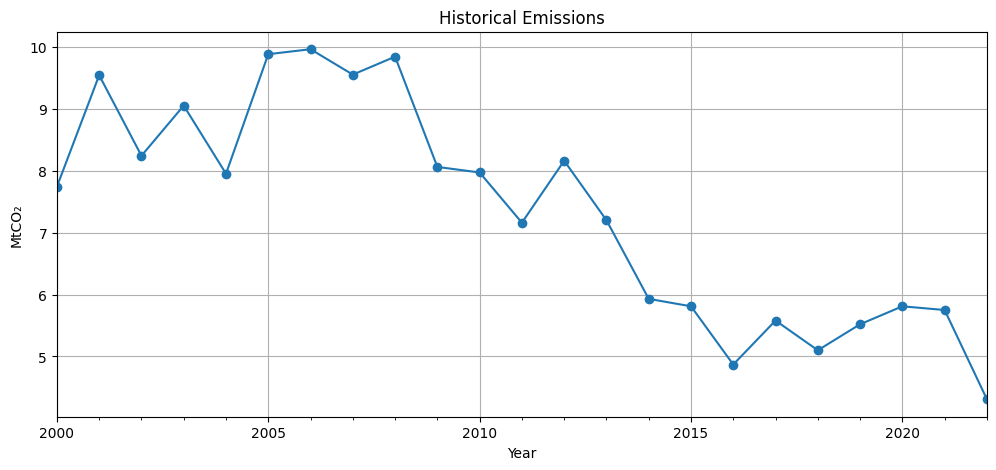

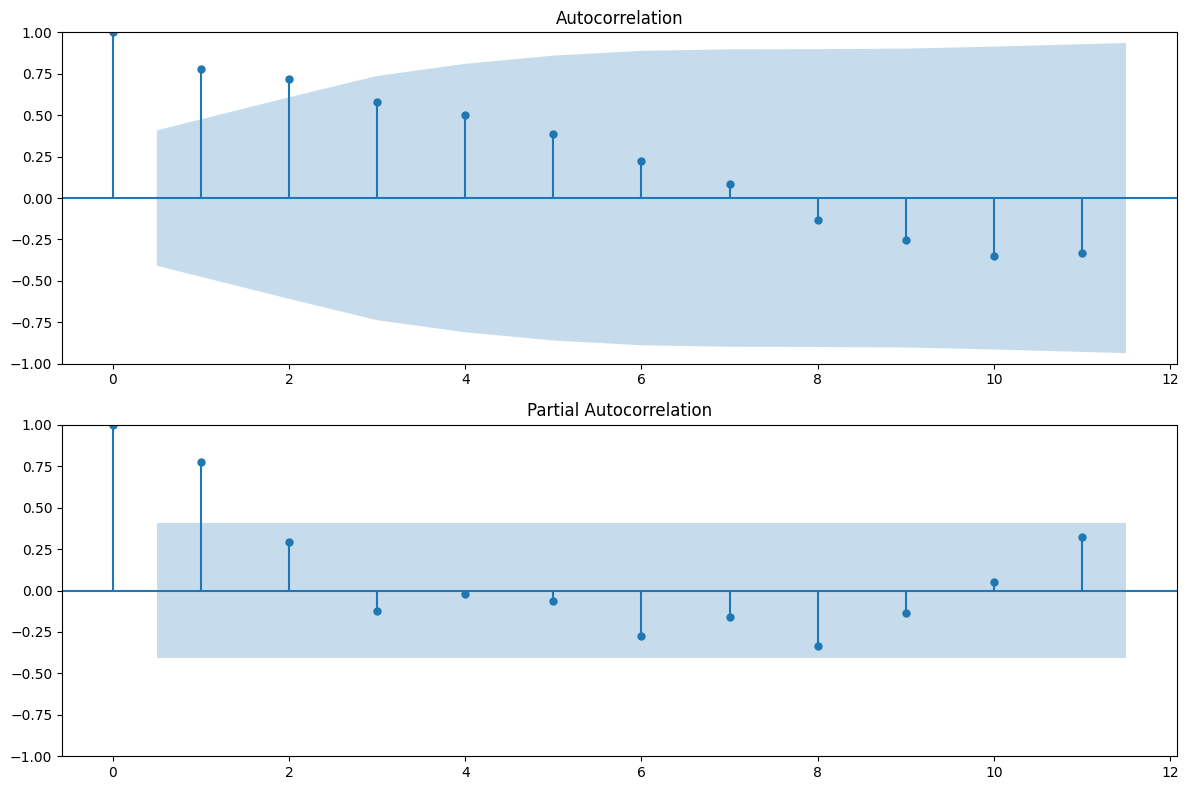


    Stationarity Test    
ADF Statistic: -6.346
p-value: 0.000
Critical Values:
   1%: -4.069
   5%: -3.127
   10%: -2.702
SARIMA(1,1,0) - MAE: 0.63
SARIMA(0,1,1) - MAE: 0.61
SARIMA(1,0,0) - MAE: 0.58

 Model Performance Metrics:

SARIMA(1,1,0):
MAE: 0.63
RMSE: 0.70
MAPE: 12.95

SARIMA(0,1,1):
MAE: 0.61
RMSE: 0.71
MAPE: 12.71

SARIMA(1,0,0):
MAE: 0.58
RMSE: 0.66
MAPE: 12.01

Naive:
MAE: 0.58
RMSE: 0.73
MAPE: 12.36

Mean:
MAE: 2.37
RMSE: 2.47
MAPE: 47.51


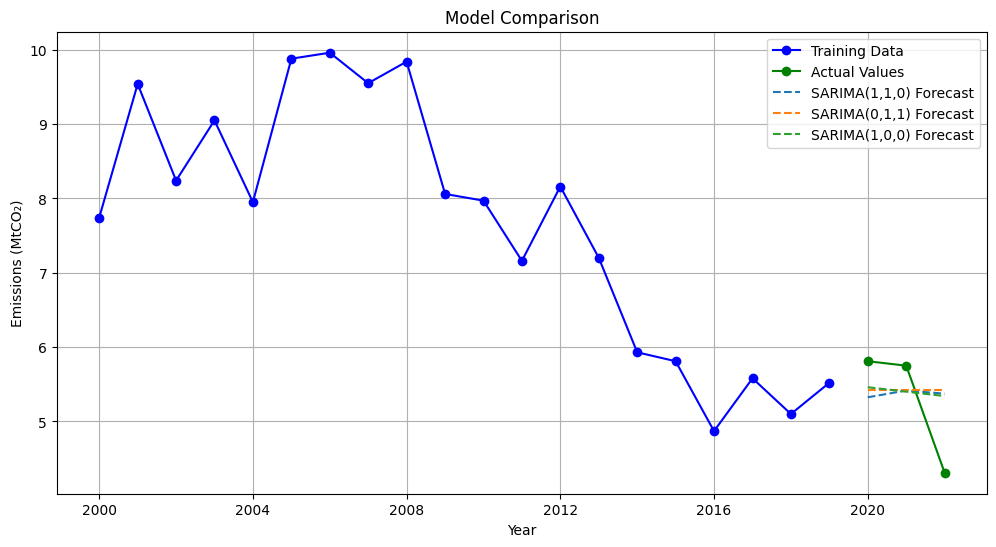


 Generating 5-Year Forecast with SARIMA(1,0,0) 


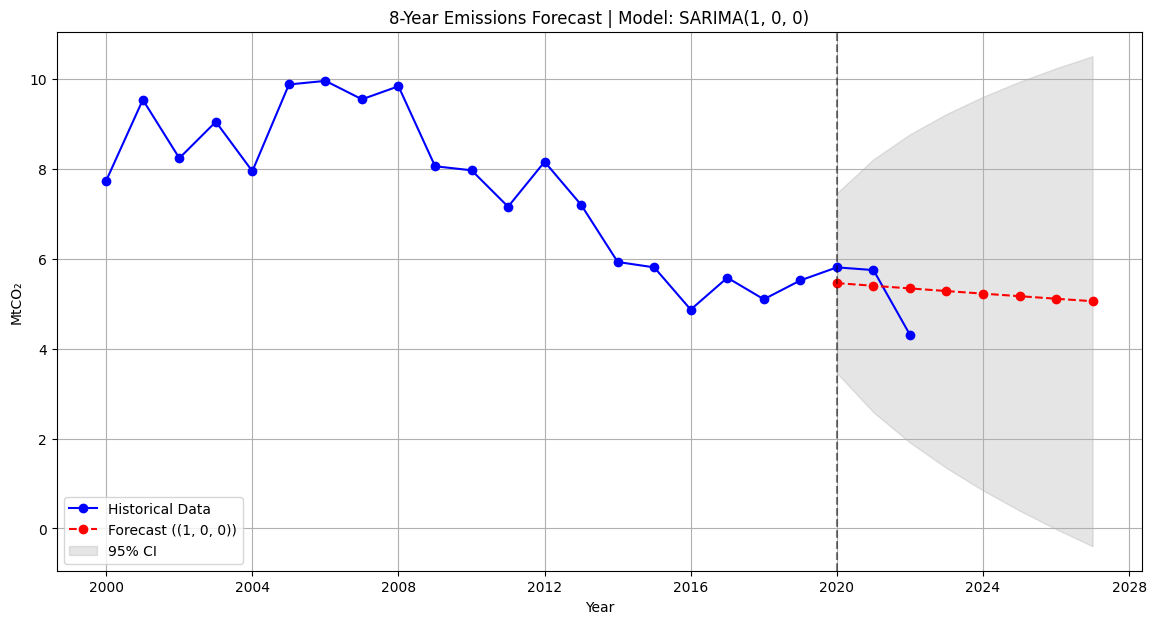


Forecasted Values with 95% CI:
greenhouse_gas_emissions      mean   mean_se  mean_ci_lower  mean_ci_upper
2020-01-01                5.459859  1.021215       3.458315       7.461403
2021-01-01                5.400373  1.436370       2.585140       8.215607
2022-01-01                5.341536  1.749665       1.912256       8.770815
2023-01-01                5.283339  2.009443       1.344903       9.221776
2024-01-01                5.225777  2.234555       0.846130       9.605424
2025-01-01                5.168842  2.434729       0.396861       9.940822
2026-01-01                5.112527  2.615782      -0.014312      10.239366
2027-01-01                5.056825  2.781531      -0.394875      10.508525

Model Diagnostics:


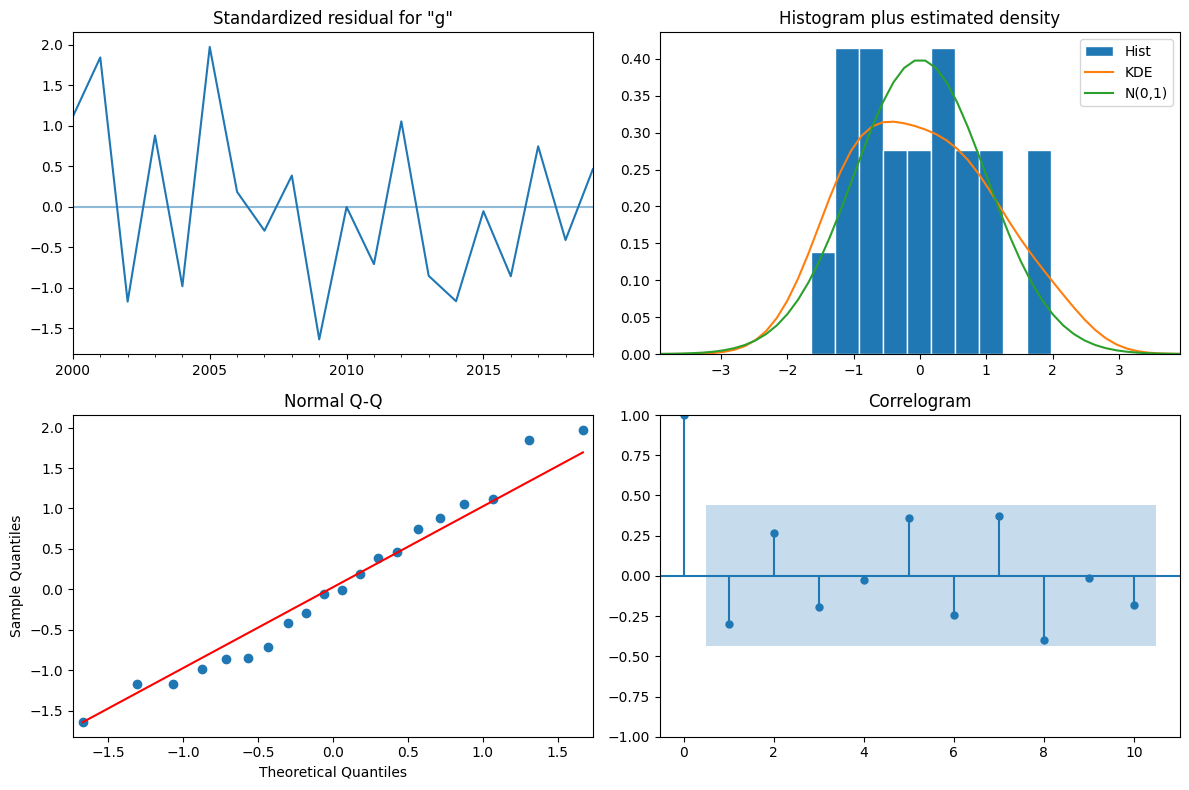

In [102]:
main()